In [1]:
%pip install datasets
%pip install h5py
%pip install ipywidgets
%pip install mlxtend  

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
# from datasets import load_dataset, Dataset
import torch
import random
import json
from tqdm import tqdm # For processing bars
import h5py
import mlxtend
import os
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split


## Part 1: Preprocessing


In [ ]:
# Define file paths (adjust these as needed)
DRUGBANK_CSV = "drug_smiles.csv"
PROTEIN_CSV = "pdb_sequences.csv"
INTERACTIONS_CSV = "confirmed_interactions.csv"  # should contain columns like "Drug id", "pdb_id"
DRUG_ENCODED_CSV = "drug_encoded.csv"
PROTEIN_ENCODED_CSV = "protein_encoded.csv"
DRUG_FCS_CSV = "drug_smiles_fcs_freq_100.csv"
PROTEIN_FCS_CSV = "protein_fcs_freq_100.csv"
MERGED_ENCODING_CSV = "merged_encodings.csv"

# --- (A) FCS Extraction and Ranking ---
# (Assume the functions extract_fcs_subsequences_stream and filter_and_rank_fcs are defined as in your code)

def extract_fcs_subsequences_stream(strings, min_length=2, max_length=None,
                                      prune_every=1000, prune_threshold=5,
                                      preserve_short_length=5):
    subseq_counter = Counter()
    for idx, s in enumerate(strings, 1):
        n = len(s)
        for i in range(n):
            current_max = n - i if max_length is None else min(max_length, n - i)
            for l in range(min_length, current_max + 1):
                subseq = s[i:i+l]
                subseq_counter[subseq] += 1
        if idx % prune_every == 0:
            subseq_counter = Counter({
                k: v for k, v in subseq_counter.items()
                if len(k) < preserve_short_length or v >= prune_threshold
            })
            print(f"Processed {idx} sequences, counter pruned to {len(subseq_counter)} keys.")
    return subseq_counter

def filter_and_rank_fcs(fcs_counts, min_frequency=100):
    filtered_items = [(subseq, freq) for subseq, freq in fcs_counts.items() if freq >= min_frequency]
    filtered_items.sort(key=lambda x: x[1], reverse=True)
    data = []
    for rank, (subseq, freq) in enumerate(filtered_items, start=1):
        data.append({"Subsequence": subseq, "Frequency": freq, "Rank": rank})
    return pd.DataFrame(data)

# Process drug SMILES FCS if not already done
drug_output_file = DRUG_FCS_CSV
if not os.path.exists(drug_output_file):
    df_drug = pd.read_csv(DRUGBANK_CSV)
    smiles_column = "smiles"
    if smiles_column not in df_drug.columns:
        raise ValueError(f"No '{smiles_column}' column found in {DRUGBANK_CSV}!")
    smiles_list = df_drug[smiles_column].dropna().astype(str).tolist()
    print("Extracting subsequences from drug SMILES...")
    smiles_fcs_counts = extract_fcs_subsequences_stream(
        smiles_list, min_length=2, max_length=10,
        prune_every=1000, prune_threshold=5, preserve_short_length=5
    )
    smiles_fcs_df = filter_and_rank_fcs(smiles_fcs_counts, min_frequency=5)
    smiles_fcs_df.to_csv(drug_output_file, index=False)
    print(f"[DRUG SMILES] Total subsequences (frequency ≥ 5): {len(smiles_fcs_df)}")
else:
    print(f"{drug_output_file} already exists. Skipping drug SMILES subsequence extraction.")

# Process protein sequences FCS similarly
protein_output_file = PROTEIN_FCS_CSV
if not os.path.exists(protein_output_file):
    df_protein = pd.read_csv(PROTEIN_CSV)
    protein_column = "sequence"
    if protein_column not in df_protein.columns:
        raise ValueError(f"No '{protein_column}' column found in {PROTEIN_CSV}!")
    protein_list = df_protein[protein_column].dropna().astype(str).tolist()
    print("Extracting subsequences from protein sequences...")
    protein_fcs_counts = extract_fcs_subsequences_stream(
        protein_list, min_length=2, max_length=10,
        prune_every=1000, prune_threshold=5, preserve_short_length=5
    )
    protein_fcs_df = filter_and_rank_fcs(protein_fcs_counts, min_frequency=5)
    protein_fcs_df.to_csv(protein_output_file, index=False)
    print(f"[PROTEIN] Total subsequences (frequency ≥ 5): {len(protein_fcs_df)}")
else:
    print(f"{protein_output_file} already exists. Skipping protein sequences subsequence extraction.")

# --- (B) Encoding ---
def encode_sequence(seq, token_dict, min_subseq_len=2):
    return [token_dict.get(seq[i:j], 0)
            for i in range(len(seq))
            for j in range(i + min_subseq_len, len(seq) + 1)]

drug_df = pd.read_csv(DRUGBANK_CSV)
protein_df = pd.read_csv(PROTEIN_CSV)
drug_dict_df = pd.read_csv(drug_output_file)
protein_dict_df = pd.read_csv(protein_output_file)
import json
if not os.path.exists(DRUG_ENCODED_CSV) or not os.path.exists(PROTEIN_ENCODED_CSV):
    drug_token_dict = dict(zip(drug_dict_df["Subsequence"], drug_dict_df["Rank"]))
    protein_token_dict = dict(zip(protein_dict_df["Subsequence"], protein_dict_df["Rank"]))
    drug_df["Encoded"] = drug_df["smiles"].apply(lambda x: encode_sequence(str(x), drug_token_dict, min_subseq_len=2))
    protein_df["Encoded"] = protein_df["sequence"].apply(lambda x: encode_sequence(str(x), protein_token_dict, min_subseq_len=2))
    drug_df.to_csv(DRUG_ENCODED_CSV, index=False)
    protein_df.to_csv(PROTEIN_ENCODED_CSV, index=False)
else:
    print(f"{DRUG_ENCODED_CSV} and {PROTEIN_ENCODED_CSV} already exist. Skipping encoding step.")

# --- (C) Merging Encoded Data with Interaction Labels ---
drug_encoded_df = pd.read_csv(DRUG_ENCODED_CSV)
protein_encoded_df = pd.read_csv(PROTEIN_ENCODED_CSV)
# Make sure to use the proper key names (e.g., "Drug id" and "pdb_id")
pdb_drug_map = pd.read_csv(INTERACTIONS_CSV)
pdb_drug_map.to_csv(INTERACTIONS_CSV, index=False)

pdb_drug_map.rename(columns={'Drug ID': 'Drug id', 'PDB ID': 'pdb_id'}, inplace=True)
print(pdb_drug_map.head())
confirmed_interactions = pd.read_csv(INTERACTIONS_CSV)
drug_encodings = pd.read_csv(DRUG_ENCODED_CSV)
protein_encodings = pd.read_csv(PROTEIN_ENCODED_CSV)
# Rename columns in confirmed_interactions for consistency (if needed)



def gen_neg_samples(confirmed_interactions):
    """
    Generate negative samples for drug-target interactions
    
    Args:
        confirmed_interactions: DataFrame with columns ['Drug id', 'pdb_id']
    Returns:
        DataFrame with negative samples
    """
    unique_prots = confirmed_interactions["pdb_id"].unique()
    unique_drugs = confirmed_interactions["Drug id"].unique()
    
    # Convert confirmed interactions to set for faster lookup
    confirmed_pairs = set(zip(confirmed_interactions["Drug id"], 
                            confirmed_interactions["pdb_id"]))
    
    # Number of negative samples to generate (2x positive samples)
    n_samples = len(confirmed_interactions) * 1
    neg_samples = []
    
    with tqdm(total=n_samples, desc="Generating negative samples") as pbar:
        while len(neg_samples) < n_samples:
            drug = random.choice(unique_drugs)
            prot = random.choice(unique_prots)
            
            # Check if this pair is not in confirmed interactions
            if (drug, prot) not in confirmed_pairs:
                neg_samples.append([drug, prot])
                pbar.update(1)
    print(len(neg_samples))
    print(len(confirmed_pairs))
    return pd.DataFrame(neg_samples, columns=["Drug id", "pdb_id"])


# Rename columns in confirmed_interactions for consistency (if needed)
confirmed_interactions.rename(columns={'Drug ID': 'Drug id', 'PDB ID': 'pdb_id'}, inplace=True)

neg_inter = gen_neg_samples(confirmed_interactions)
print(neg_inter.head())

confirmed_interactions['label'] = 1
neg_inter['label'] = 0

# Combine positive and negative samples
confirmed_interactions = pd.concat([confirmed_interactions, neg_inter], ignore_index=True)
print("Confirmed")
confirmed_interactions = confirmed_interactions.sample(frac=1, random_state=42).reset_index(drop=True)
print(confirmed_interactions.head())
# Merge on common identifiers (assuming columns "Drug id" and "pdb_id")
merged_df = pdb_drug_map.merge(drug_encoded_df, on='Drug id', how='inner')
merged_df = merged_df.merge(protein_encoded_df, on='pdb_id', how='inner')

if not os.path.exists(MERGED_ENCODING_CSV):
    merged_df.to_csv(MERGED_ENCODING_CSV, index=False)
    print(f"File {MERGED_ENCODING_CSV} created.")
else:
    print(f"File {MERGED_ENCODING_CSV} already exists. Skipping save.")


drug_smiles_fcs_freq_100.csv already exists. Skipping drug SMILES subsequence extraction.
protein_fcs_freq_100.csv already exists. Skipping protein sequences subsequence extraction.
drug_encoded.csv and protein_encoded.csv already exist. Skipping encoding step.
   Drug id pdb_id
0  DB05383   1NSI
1  DB08814   1NSI
2  DB08814   1MDI
3  DB09092   1DJL
4  DB09092   3ERY


Generating negative samples: 100%|██████████| 968/968 [00:00<00:00, 472267.80it/s]

968
968
   Drug id pdb_id
0  DB14059   1I7G
1  DB00631   3GC8
2  DB00202   1ISF
3  DB06202   1AII
4  DB00509   1WWC
Confirmed
   Drug id pdb_id  label
0  DB06211   3OC2      1
1  DB05015   3C5K      1
2  DB06603   4A69      1
3  DB00634   1YQ7      0
4  DB00799   4D01      0
File merged_encodings.csv already exists. Skipping save.


## Part 2: Association Rule Mining for DTI Prediction

- For association rule mining we only need the interaction information.
- We use the confirmed interactions from the merged file.
- (Assume merged_df contains columns: "Drug id", "pdb_id", and "label")
- If your merged_df contains extra encoded columns, we ignore them.

In [4]:
interactions = confirmed_interactions[['Drug id', 'pdb_id', 'label']].copy()

# Split into training and test sets (by rows)
train_interactions, test_interactions = train_test_split(interactions, test_size=0.3, random_state=42)

def build_transaction_matrix(df):
    """Build binary transaction matrix for positive interactions."""
    pos_df = df[df['label'] == 1]
    trans = pos_df.pivot_table(index='Drug id', columns='pdb_id', aggfunc='size', fill_value=0)
    trans = trans.applymap(lambda x: 1 if x >= 1 else 0)
    return trans

# Build training transaction matrix
train_matrix = build_transaction_matrix(train_interactions)
print("Training Transaction Matrix:")
print(train_matrix.head())


test_matrix = build_transaction_matrix(test_interactions)
print("\nTest Transaction Matrix (first 5 rows):")
print(test_matrix.head())

# Mine frequent itemsets and association rules
min_support = 0.003 # Adjust as needed
min_confidence = 0.5
frequent_itemsets = apriori(train_matrix, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
print("Mined Association Rules:")
if not rules.empty:
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("No rules mined with current thresholds.")


def predict_dti(drug_id, protein_id, transaction_matrix, rules, confidence_threshold=0.2):
    if drug_id not in transaction_matrix.index:
        return 0, 0.0
    known_proteins = set(transaction_matrix.columns[transaction_matrix.loc[drug_id] == 1])
    matching = rules[
        rules['antecedents'].apply(lambda x: x.issubset(known_proteins)) &
        rules['consequents'].apply(lambda x: protein_id in x)
    ]
    if matching.empty:
        return 0, 0.0
    # Instead of averaging, you might take the maximum confidence
    max_conf = matching['confidence'].max()
    pred = 1 if max_conf >= confidence_threshold else 0
    return pred, max_conf




C:\Users\Administrator\AppData\Local\Temp\ipykernel_41736\3357554742.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trans = trans.applymap(lambda x: 1 if x >= 1 else 0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41736\3357554742.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trans = trans.applymap(lambda x: 1 if x >= 1 else 0)
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Training Transaction Matrix:
pdb_id   12CA  1A02  1A07  1A28  1A31  1A3Q  1A52  1A5H  1A5K  1A85  ...  \
Drug id                                                              ...   
DB00131     0     0     0     0     0     0     0     0     0     0  ...   
DB00140     0     0     0     0     0     0     0     0     0     0  ...   
DB00148     0     0     0     0     0     0     0     0     0     0  ...   
DB00159     0     0     0     0     0     0     0     0     0     0  ...   
DB00182     0     0     0     0     0     0     0     0     0     0  ...   

pdb_id   4MQE  4MZ2  4RED  4V11  4WUR  4Z9M  4ZK4  5CFB  5UWI  6A69  
Drug id                                                              
DB00131     0     0     1     0     0     0     0     0     0     0  
DB00140     0     0     0     0     0     0     0     0     0     0  
DB00148     0     0     0     0     0     0     0     0     0     0  
DB00159     0     0     0     0     0     0     0     0     0     0  
DB00182     0     


Association Rule Mining Evaluation Metrics:
{'accuracy': 0.7039586919104991, 'confusion_matrix': array([[281,   0],
       [172, 128]], dtype=int64), 'roc_auc': 0.7133333333333334, 'pr_auc': 0.8613539873780838}


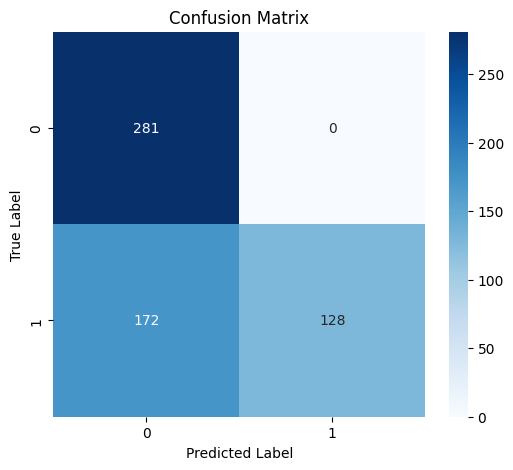

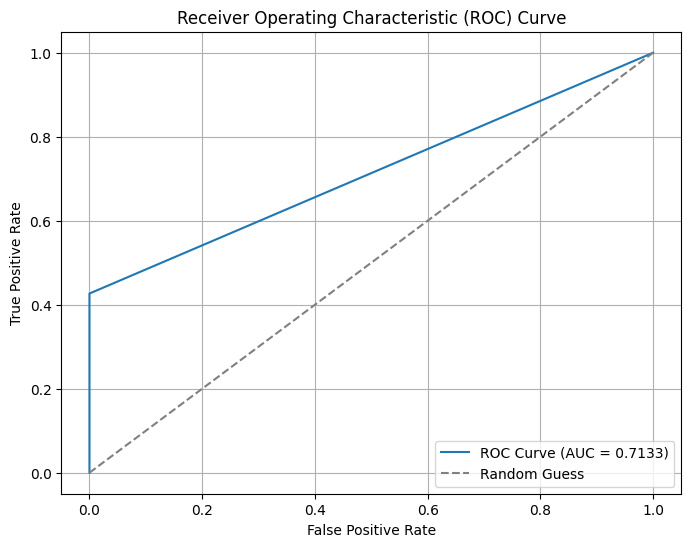

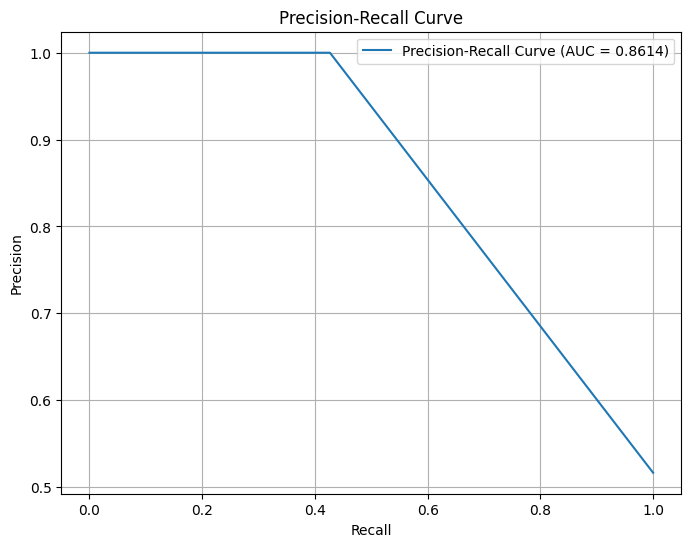


Example Prediction for Drug DB06616 and Protein 1NFI:
Predicted Label: 0, Average Rule Confidence: 0.0000


In [5]:
def evaluate_model(test_df, transaction_matrix, rules, confidence_threshold):
    preds, confs, trues = [], [], []
    for _, row in test_df.iterrows():
        d_id = row['Drug id']
        p_id = row['pdb_id']
        true_label = row['label']
        pred, conf = predict_dti(d_id, p_id, transaction_matrix, rules, confidence_threshold)
        preds.append(pred)
        confs.append(conf)
        trues.append(true_label)
    acc = accuracy_score(trues, preds)
    cm = confusion_matrix(trues, preds)
    try:
        roc_auc = roc_auc_score(trues, confs)
    except:
        roc_auc = None
    precision, recall, _ = precision_recall_curve(trues, confs)
    pr_auc = auc(recall, precision)
    return {
        "accuracy": acc,
        "confusion_matrix": cm,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

metrics = evaluate_model(test_interactions, train_matrix, rules, confidence_threshold=0.5)
print("\nAssociation Rule Mining Evaluation Metrics:")
print(metrics)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# For ROC and PR curves, first extract the prediction confidence values from test data.
def get_evaluation_data(test_df, transaction_matrix, rules, confidence_threshold):
    preds, confs, trues = [], [], []
    for _, row in test_df.iterrows():
        d_id = row['Drug id']
        p_id = row['pdb_id']
        true_label = row['label']
        pred, conf = predict_dti(d_id, p_id, transaction_matrix, rules, confidence_threshold)
        preds.append(pred)
        confs.append(conf)
        trues.append(true_label)
    return np.array(trues), np.array(confs), np.array(preds)

trues, confs, preds = get_evaluation_data(test_interactions, train_matrix, rules,confidence_threshold=0.5)

# ROC Curve (if both classes exist)
if np.any(trues == 0) and np.any(trues == 1):
    fpr, tpr, _ = roc_curve(trues, confs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("ROC Curve cannot be plotted because one of the classes is missing in the test set.")

# Precision-Recall Curve
if np.any(trues == 1):
    precision, recall, _ = precision_recall_curve(trues, confs, pos_label=1)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
else:
    print("Precision-Recall Curve cannot be plotted because there are no positive samples in the test set.")

###############################################
# Part 5: Example Prediction on a Test Pair
###############################################

example_row = test_interactions.iloc[0]
ex_drug = example_row['Drug id']
ex_prot = example_row['pdb_id']
pred, conf = predict_dti(ex_drug, ex_prot, train_matrix, rules, confidence_threshold=0.5)
print(f"\nExample Prediction for Drug {ex_drug} and Protein {ex_prot}:")
print(f"Predicted Label: {pred}, Average Rule Confidence: {conf:.4f}")

